INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'cement_cat': 'O', 'water_cat': 'O', 'ash_cat': 'O', 'superplastic_cat': 'O', 'strength_cat': 'O'}


CPD of cement_cat:
+--------------------+----------+
| cement_cat(high)   | 0.333981 |
+--------------------+----------+
| cement_cat(low)    | 0.333981 |
+--------------------+----------+
| cement_cat(medium) | 0.332039 |
+--------------------+----------+

CPD of strength_cat:
+----------------------+-----+--------------------------+
| ash_cat              | ... | ash_cat(medium)          |
+----------------------+-----+--------------------------+
| cement_cat           | ... | cement_cat(medium)       |
+----------------------+-----+--------------------------+
| superplastic_cat     | ... | superplastic_cat(medium) |
+----------------------+-----+--------------------------+
| water_cat            | ... | water_cat(medium)        |
+----------------------+-----+--------------------------+
| strength_cat(high)   | ... | 0.0                      |
+----------------------+-----+--------------------------+
| strength_cat(low)    | ... | 0.0                      |
+----------------------+-

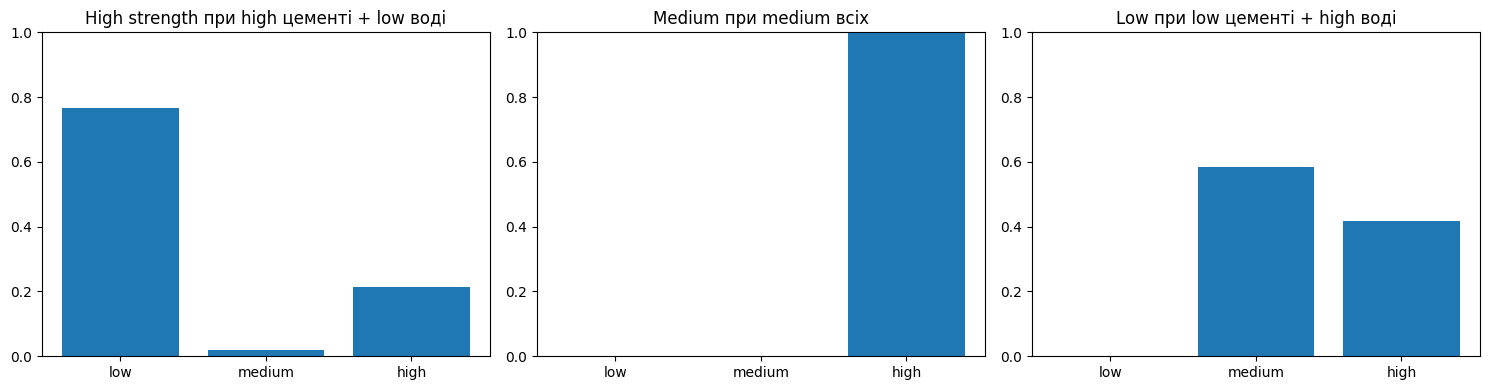

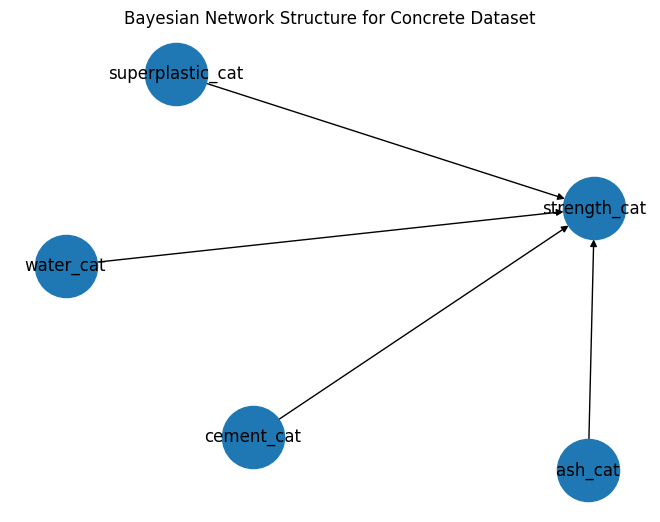

In [1]:
import pandas as pd
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination
from pyvis.network import Network
import matplotlib.pyplot as plt
import networkx as nx

# 1. Завантаження даних
data = pd.read_csv('concrete.csv')

# 2. Функція для надійної дискретизації в 3 біну
def safe_discretize(series, labels=['low','medium','high']):
    try:
        # спочатку пробуємо рівні квантілі
        return pd.qcut(series, q=3, labels=labels, duplicates='raise')
    except ValueError:
        # якщо з’явились дублікати меж — робимо просто рівномірне розбиття
        return pd.cut(series, bins=3, labels=labels)

# 3. Дискретизація компонентів
for col in ['cement', 'water', 'ash', 'superplastic']:
    data[f'{col}_cat'] = safe_discretize(data[col])

# 4. Дискретизація strength
data['strength_cat'] = safe_discretize(data['strength'])

# 5. Визначення структури Байєсової мережі
model = DiscreteBayesianNetwork([
    ('cement_cat',       'strength_cat'),
    ('water_cat',        'strength_cat'),
    ('ash_cat',          'strength_cat'),
    ('superplastic_cat', 'strength_cat'),
])

# 6. (Опційно) Візуалізація структури
net = Network(notebook=True, cdn_resources='in_line')
net.from_nx(model)
html = net.generate_html()   # отримуємо весь HTML у рядку
with open('bayesian_network.html', 'w', encoding='utf-8') as f:
    f.write(html)

# 7. Навчання моделі
train_cols = ['cement_cat','water_cat','ash_cat','superplastic_cat','strength_cat']
model.fit(data[train_cols], estimator=MaximumLikelihoodEstimator)

# 8. Вивід CPD
for cpd in model.get_cpds():
    print(f"CPD of {cpd.variable}:\n{cpd}\n")

# 9. Інференс
infer = VariableElimination(model)

queries = {
    "High strength при high цементі + low воді": {
        'cement_cat':'high','water_cat':'low','ash_cat':'low','superplastic_cat':'medium'
    },
    "Medium при medium всіх": {
        'cement_cat':'medium','water_cat':'medium','ash_cat':'medium','superplastic_cat':'medium'
    },
    "Low при low цементі + high воді": {
        'cement_cat':'low','water_cat':'high','ash_cat':'medium','superplastic_cat':'low'
    },
}

for desc, ev in queries.items():
    q = infer.query(variables=['strength_cat'], evidence=ev)
    print(f"{desc}:\n{q}\n")

# 10. Візуалізація
labels = ['low','medium','high']
plt.figure(figsize=(15,4))
for i,(desc,ev) in enumerate(queries.items(),1):
    q = infer.query(variables=['strength_cat'], evidence=ev)
    plt.subplot(1,3,i)
    plt.bar(labels, q.values)
    plt.title(desc, wrap=True)
    plt.ylim(0,1)
plt.tight_layout()
plt.show()

G = nx.DiGraph()
G.add_nodes_from(model.nodes())
G.add_edges_from(model.edges())
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=2000, arrows=True)
plt.title("Bayesian Network Structure for Concrete Dataset")
plt.show()